In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import os

import rain

Using TensorFlow backend.


In [15]:
rain.setCUDAVisible("0, 1")

MODEL_NAME = input("Model name: ")
DATA_CACHE = "data/df-cache.csv"
FREQUENCY = 30
TIMESTEP_LEN = 100
VALIDATION_RATIO = 0.15
EPOCHS = 16
BATCH_SIZE = 512

Model name: 2


In [29]:
#model
model = keras.models.Sequential()
#timesteps of history - with a vector of size 1 per timestep
model.add(keras.layers.GRU(64, input_shape = (TIMESTEP_LEN, 1), return_sequences = True))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("tanh"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.GRU(64))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("tanh"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Activation("linear"))
model.compile(loss = "mean_squared_logarithmic_error", 
    optimizer = keras.optimizers.adam(lr = 0.0003))

c:\ProgramData\Miniconda3\envs\inmensus\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


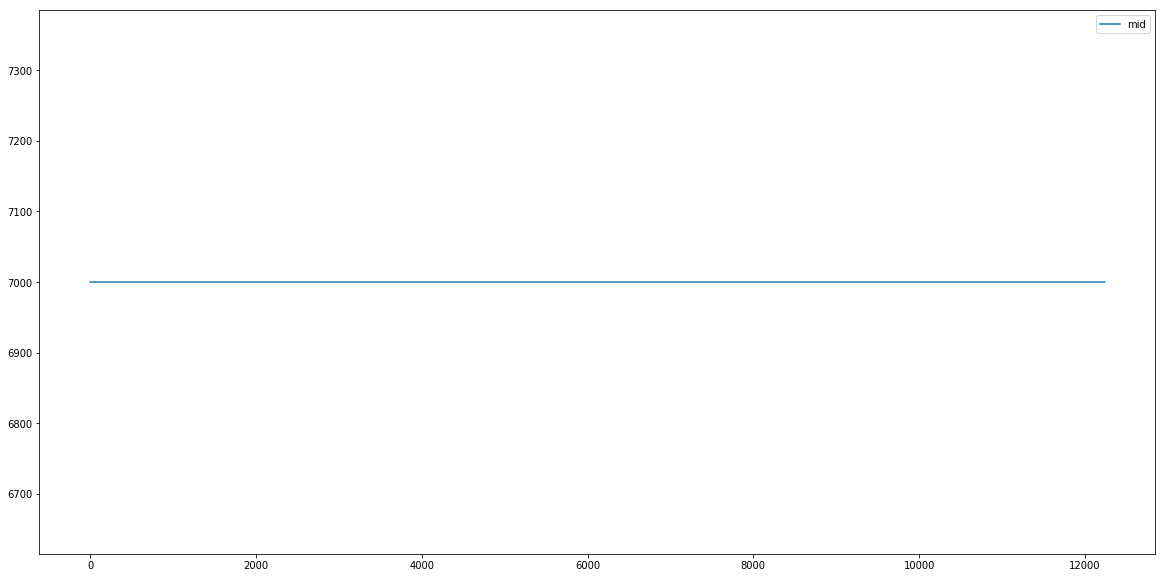

In [34]:
#data
df = pd.read_csv(rain.toRelPath(DATA_CACHE))
df = df.iloc[::int(2 * FREQUENCY), :]
df.reset_index(inplace = True)
mid = df["mid"]
mid.fillna(method = "bfill", inplace = True)

mid[mid != 0] = 7000

plt.figure(figsize = (20, 10))
plt.plot(mid)
plt.legend()
plt.show()

In [35]:
#prep
train = [[], []]
for a in range(len(mid) - TIMESTEP_LEN):
    train[0].append(mid[a:a + TIMESTEP_LEN].values)
    train[1].append(mid[a + TIMESTEP_LEN])
train[0] = np.reshape(train[0], (len(train[0]), TIMESTEP_LEN, 1))
print("Patters:", len(train[0]))

valCount = int(VALIDATION_RATIO * len(train[0]))
validation = [train[0][-valCount:], train[1][-valCount:]]
train = [train[0][:-valCount], train[1][:-valCount]]
print(len(train[0]), len(validation[0]))
print(train[0][0], train[1][0])

Patters: 12140
10319 1821
[[7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]
 [7000.]] 7000.0


In [ ]:
#fit
model.fit(
    train[0], 
    train[1], 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            rain.toRelPath("weights/" + MODEL_NAME + "_{epoch}_{val_loss:.4f}.h5"), 
            save_weights_only = True
        )
    ],
    validation_data = (
        validation[0], 
        validation[1])
    )

Train on 10319 samples, validate on 1821 samples
Epoch 1/16
10319/10319 [==============================] - 79s 8ms/step - loss: 62.9723 - val_loss: 53.1471
Epoch 2/16
10319/10319 [==============================] - 83s 8ms/step - loss: 53.8881 - val_loss: 53.3796
Epoch 3/16
 1152/10319 [==>...........................] - ETA: 1:04 - loss: 50.8928